# Load data

In [39]:
from pathlib import Path
import numpy as np
import logging
import csv
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
_initialized = True
def load_data_from_file(data_path, is_train):
    x_path = data_path/('train/' if is_train else 'test/')
    targets_path = data_path/('y_train.csv' if is_train else 'y_test.csv')
    if not x_path.exists():
        logger.warning("Data couldn't be loaded.")
    else:
        distance_maps = []
        masks = []
        for file in x_path.iterdir():
            if file.name.endswith("distance.npy"):
                distance_maps.append(np.load(file))
            if file.name.endswith("mask.npy"):
                seq = np.load(file)
                mask2d = np.full((len(seq),len(seq)),seq)
                mask2d = np.logical_and(mask2d,mask2d.T)
                mask2d = np.where(mask2d != True, 0, 1)
                masks.append(mask2d)
        with open(targets_path) as file:
            targets = csv.reader(file)
            targets = np.array(np.delete(np.array(list(targets)), 0, 1),dtype=int) #remove Protein IDs
        if (len(masks)!= 0 and len(distance_maps) == len(masks) and len(masks) == len(targets)):
            logger.info("Data was sucessfully loaded.")
    return np.array(distance_maps), targets #np.array([np.array(distance_maps), masks]), targets
# needs folderstructure: folder data, inside: 2 csv files for y, 2 subfolders test and train containing x data
data_path = Path('data')

x_train, y_train = load_data_from_file(data_path, True)
x_test, y_test = load_data_from_file(data_path, False)

# Prepare & split data
sinnvollen split wählen, nicht alle großen proteine in einem split  
nicht  mehr als 100 testsamples aber sollen representativ sein (test, val, train)

In [40]:
import torch #        torch.tensor([1.]).cuda()
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')

class myDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # TODO right now no masks, add masks back in
        sample = [tf.to_tensor(self.x_data[idx]), self.y_data[idx]]
        return sample
    
valid_part = 0.1          # percentage of validation set samples
random_seed = 3651        # for repeatable experiments
batch_size = 1            # 64 TODO problem diff sizes
num_workers=4
pin_memory=True

train_data= myDataset(x_train,y_train)
valid_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)

# Split data to training and validation

indices = list(range(len(x_train)))
split = int(np.floor(len(x_train)*valid_part))
np.random.seed(random_seed) 
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory,sampler=train_sampler)
valid_loader = DataLoader(valid_data,batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

# TODO which format targets? right now: metal, small, nucleus
# TODO crossvalidation
# TODO load ids seperately
# TODO Reduce class imbalance > weights loss fct try
# right now no batches cause problem with different sizes

# Network architecture
INPUT: distance maps + mask (problem different sizes, fc unmöglich), LxLx2 TODO mask to 2d  
2d convs (wieviele filter kernel, wieviele conv layer)  
mitte LxLx64 (depends on amount convs)  
global avg/max pooling avg over LxL  -> 1x64  
OUTPUT: 3 classes  
batch size 1, 1 sample per iteration  
what against overfitting, for normalization?

In [41]:
from torch import nn, optim

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d(1)
)
model.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): AdaptiveAvgPool2d(output_size=1)
)

# Training

Training started
Train Epoch: 1 [0/933 (0%)]	Loss: 0.411
Train Epoch: 1 [100/933 (11%)]	Loss: 1.045
Train Epoch: 1 [200/933 (21%)]	Loss: 0.430
Train Epoch: 1 [300/933 (32%)]	Loss: 0.487
Train Epoch: 1 [400/933 (43%)]	Loss: 0.397
Train Epoch: 1 [500/933 (54%)]	Loss: 0.450
Train Epoch: 1 [600/933 (64%)]	Loss: 0.463
Train Epoch: 1 [700/933 (75%)]	Loss: 0.674
Train Epoch: 1 [800/933 (86%)]	Loss: 0.943
Train Epoch: 1 [900/933 (96%)]	Loss: 0.402


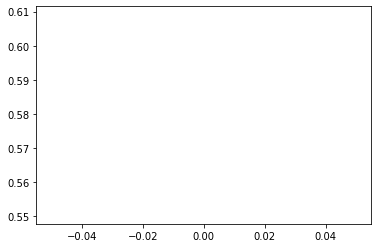

<class 'list'>


TypeError: list indices must be integers or slices, not tuple

In [59]:
#TODO problem: loss not decreasing
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

#gain = nn.init.calculate_gain('leaky_relu', 0.2)
#TODO weights initialization, xavier
lr = 0.0001
epochs = 10

opt = optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.BCEWithLogitsLoss()
all_y_pred = []

def train(train_loader, model, epoch, loss_func, opt):
    model.train()
    loss_sum = 0
    loss_avg = []
    i = 0
    print('Training started')
    for batch_idx, (x,y) in enumerate(train_loader):
        x = x.to(device).float()
        y = y.to(device)
        opt.zero_grad()
        y_pred = model(x)
        y_pred = y_pred.view_as(y) #TODO maybe needs to change with bigger batchsize
        all_y_pred.append(y_pred)
        i += 1
        
        loss = loss_func(y_pred, y.float())
        loss.backward()
        opt.step()
        loss_sum += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_idx * len(x), len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))

    loss_avg.append(loss_sum / len(train_loader))
    plt.plot(loss_avg)
    plt.show()
    
    # calculate MCC
    print(type(list(enumerate(train_loader))))
    all_y = list(enumerate(train_loader))[:,1][1]
    print(all_y)
    print(all_y_pred)
    #TOdo not do per sample but per list
    #get list of y and list of y_pred
    m = nn.LogSigmoid()
    y_pred = m(y_pred)
    print(y_pred)
    y_pred = 1*(y_pred >= 0.5)
    train_scores = {}
    print(y, y_pred)
    #matthews_corrcoef(y_true, y_pred, sample_weight=None)

    train_scores['mcc_metal'] = matthews_corrcoef(y, y_pred[:,0])
    train_scores['mcc_small'] = matthews_corrcoef(y, y_pred[:,1])
    train_scores['mcc_nucleus'] = matthews_corrcoef(y, y_pred[:,2])
    print('Train Epoch: {}\tAverage Loss: {:.3f}\tMCC: {}'.format(epoch, loss_avg, train_scores))
    
    with open('result/train_mcc.txt', 'a') as f:
        f.write(str(trainscores) + os.linesep)
    f.close()
    with open('result/train_loss.txt', 'a') as f:
        f.write(str(loss_avg) + os.linesep)
    f.close()
 
for epoch in range (1, epochs + 1):
    train(train_loader, model, epoch, loss_func, opt)
    #test(test_loader, model, epoch, loss_func, RESUME)

In [80]:
all_y = np.array(list(enumerate(train_loader)))
print(all_y[:,1])
#TODO continue here, goal: get sepereate lists of y_pred and y not just single samples

[list([tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64), tensor([[1, 0, 0]])])
 list([tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64), tensor([[1, 1, 0]])])
 list([tensor([[[[ 0.0000,  0.0000,  0.0000,  ..., 48.1534, 50.6323, 53.2989],
          [ 0.0000,  0.0000,  0.0000,  ..., 48.1534, 50.6323, 53.2989],
          [ 0.0000,  0.0000,  0.0000,  ..., 48.1534, 50.6323, 53.2989],
          ...,
          [48.1534, 48.1534, 48.1534,  ...,  0.0000,  3.8036,  7.3495],
          [50.6323, 50.6323, 50.6323,  ...,  3.8

# Testing

In [ ]:
#number hyperparameters
params = list(model.parameters())
print(len(params))